# Text Classification on Noisy IMDB Dataset using TPOT

## 1. Experiment Details
|Specification|Value|
|----|----|
|AutoML Framework|TPOT|
|Task|Binary Text Classification|
|Dataset|IMDB Movie Reviews|
|Dataset Clean|No|
|Noise Type|Random|

## 2. Load Packages

In [1]:
# Packages for data processing
import numpy as np
import pandas as pd
from scripts.add_noise import add_gaussian_noise, add_random_noise
from scripts.data_preprocess import preprocess_text
from sklearn.model_selection import train_test_split

# Packages for AutoML framework execution
from tpot import TPOTClassifier
from tpot.export_utils import set_param_recursive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Packages for evaluation plots
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scripts.plot_model_scores import get_plot_model

random_state = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yogesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Load and Pre-process Dataset

In [2]:
# Gaussian noisy data is already computed and stored as dataset. However, the below code snippet can be used to generate new noisy data.
# """
df = pd.read_csv("../datasets/clean/imdb.csv")
noisy_df = df.copy()
noisy_df['review'] = noisy_df['review'].apply(lambda x: add_gaussian_noise(x, mean=0, std_dev=0.6))
noisy_df.to_csv("../datasets/noisy/imdb_noisy_gaussian.csv")
# """

# Get the required dataset from the datasets folder
imdb_df = pd.read_csv("../datasets/noisy/imdb_noisy_gaussian.csv", index_col=0)

In [3]:
# Random noisy data is already computed and stored as dataset. However, the below code snippet can be used to generate new noisy data.
# """
df = pd.read_csv("../datasets/clean/imdb.csv")
noisy_df = df.copy()
noisy_df['review'] = noisy_df['review'].apply(lambda x: add_random_noise(x, noise_level=0.1))
noisy_df.to_csv("../datasets/noisy/imdb_noisy_random.csv")
# """

# Get the required dataset from the datasets folder
imdb_df = pd.read_csv("../datasets/noisy/imdb_noisy_random.csv", index_col=0)

In [4]:
# Sample the data for experimentation purposes
# Some AutoML frameworks can take long time to test multiple pipelines on large-scale data (e.g. 4+ hours on 50K+ text data)
imdb_df = imdb_df.sample(frac=0.2, replace=False, random_state=random_state)

In [5]:
# Certain AutoML frameworks such as TPOT require the target variable to be explicitly named as 'target'
imdb_df.reset_index(inplace=True)
imdb_df.rename(columns={'sentiment':'target'}, inplace=True)
imdb_df['target'] = imdb_df['target'].apply(lambda x: 1 if x =='positive' else 0)

In [6]:
# Pre-process the text to lower case, remove stopwords, lemmatize, etc.
imdb_df['tokenized_review'] = imdb_df['review'].apply(preprocess_text)

In [7]:
# Create a Word2Vec model and obtain embeddings for all the reviews in the dataset
from gensim.models import Word2Vec

sentences = imdb_df['tokenized_review'].tolist()
w2v_model_path = "word2vec_imdb"
w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, sg=0)
w2v_model.save(f"{w2v_model_path}.model")

In [8]:
if w2v_model is None: w2v_model = Word2Vec.load(f'{w2v_model_path}.model')

def get_w2v_average_embedding(tokens):
  # Calculate average word embedding for the tokens in a row
  vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
  if vectors: 
    return sum(vectors) / len(vectors)
  else:
    return None
  
imdb_df['review_embeddings'] = imdb_df['tokenized_review'].apply(get_w2v_average_embedding)

In [9]:
imdb_df.head()

,index,review,target,tokenized_review,review_embeddings
0,33553,I really lTked this Summerslam due tB the lvok...,1,"[really, ltked, summerslam, due, tb, lvok, ofr...","[-0.046897937, -0.31579578, -0.3297809, -0.566..."
1,9427,Not tany delevision shows appeal to vuOte Ds m...,1,"[tany, delevision, show, appeal, vuote, d, man...","[-0.06993935, -0.39834782, -0.39500913, -0.698..."
2,199,The film Suickly gets to a mTjor chase sccne w...,0,"[film, suickly, get, mtjor, chase, sccne, eker...","[-0.09500944, -0.41860768, -0.40264693, -0.719..."
3,12447,JanT Austen would definiDely approve of this o...,1,"[jant, austen, would, definidely, approve, oze...","[-0.10157503, -0.42611623, -0.36409375, -0.722..."
4,39489,EHYebtations were soZewhat high forume wHenlI ...,0,"[ehyebtations, sozewhat, high, forume, whenli,...","[-0.06871776, -0.33967227, -0.33042997, -0.593..."


## 4. Find Best Model using AutoML

In [10]:
# Split the dataset into traning and testing splits
X_train, X_test, y_train, y_test = train_test_split(np.vstack(imdb_df['review_embeddings']),
                                                    imdb_df.loc[:, 'target'], 
                                                    train_size=0.75, test_size=0.25, random_state=random_state)

In [11]:
# Run the TPOT framework to run its optimization (note: this may take a long time depending on the dataset)
# The current configuration takes about 15-30 minutes to complete
tpot = TPOTClassifier(generations=2, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/150 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6617333333333333

Generation 2 - Current best internal CV score: 0.6617333333333333

Best pipeline: LinearSVC(FastICA(input_matrix, tol=0.30000000000000004), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=1e-05)


TPOTClassifier(generations=2, population_size=50, random_state=42, verbosity=2)

In [12]:
# Export the pipeline configuration for direct future use
tpot.export('textclf_noisydata_tpot_bestmodelpipeline.py')

## 5. Train Model

In [16]:
# Now, we fit the model as suggested by the TPOT framework to the dataset and make predictions
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

automl_model = make_pipeline(
    Normalizer(norm="l2"),
    # LinearSVC(C=15.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)
    LinearSVC(C=0.5, dual=True, loss="squared_hinge", penalty="l2", tol=1e-05)
)

# Fix TPOT random state for all the steps in exported pipeline
set_param_recursive(automl_model.steps, 'random_state', random_state)

automl_model.fit(X_train, y_train)
y_pred_automl = automl_model.predict(X_test)

## 6. Evaluate Model

In [17]:
# We now evaluate our model performances on this dataset and compare against the Naive Bayes benchmark
precision_automl = precision_score(y_true=y_test, y_pred=y_pred_automl)
recall_automl = recall_score(y_true=y_test, y_pred=y_pred_automl)
f1_automl = f1_score(y_true=y_test, y_pred=y_pred_automl)

model_names = ['AutoML-TPOTLinearSVC']
plot_title = 'Noisy Data - TPOT Performance'
f1_scores = [f1_automl]
recall_scores = [recall_automl]
precision_scores = [precision_automl]

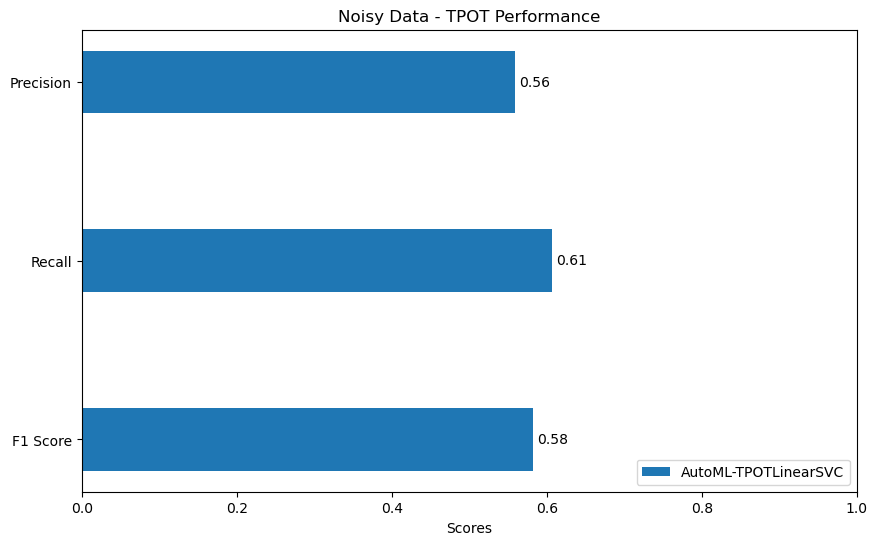

In [18]:
fig = get_plot_model(model_names=model_names, f1_scores=f1_scores, recall_scores=recall_scores, precision_scores=precision_scores, title=plot_title)
plt.show()